In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/mehradaria/leukemia')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ramesh9354
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mehradaria/leukemia


100%|██████████| 110M/110M [00:00<00:00, 1.37GB/s]

In [3]:
!nvidia-smi

Sat Sep  6 10:05:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#Import model

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout



#Import dataset

In [6]:
train_dir = "/content/leukemia/Segmented"

#Preprocess Data

In [7]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% training, 20% validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 2607 images belonging to 4 classes.
Found 649 images belonging to 4 classes.


#Load VGG16

In [8]:
# Load pretrained VGG16 without top layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False   # freeze feature extractor

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(4, activation="softmax")(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


#Train model

In [9]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 72s 699ms/step - accuracy: 0.4044 - loss: 1.3000 - val_accuracy: 0.6703 - val_loss: 1.0864
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 538ms/step - accuracy: 0.7243 - loss: 0.9405 - val_accuracy: 0.6841 - val_loss: 0.9611
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 545ms/step - accuracy: 0.8016 - loss: 0.7518 - val_accuracy: 0.6841 - val_loss: 0.8985
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 537ms/step - accuracy: 0.8062 - loss: 0.6486 - val_accuracy: 0.6795 - val_loss: 0.8501
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 521ms/step - accuracy: 0.8214 - loss: 0.5938 - val_accuracy: 0.7119 - val_loss: 0.8138
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 46s 565ms/step - accuracy: 0.8425 - loss: 0.5439 - val_accuracy: 0.7242 - val_loss: 0.7933
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 530ms/step - accuracy: 0.8580 - loss: 0.5023 - val_accuracy: 0.7257 - val_loss: 0.7763
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 530ms/step - accuracy: 0.8425 - loss: 0.4830 - val_accu

#Check Training & Validation Accuracy

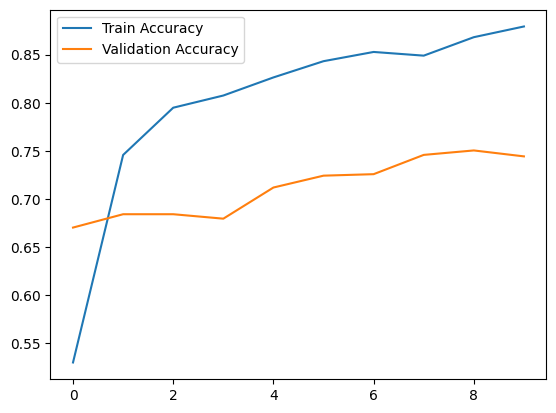

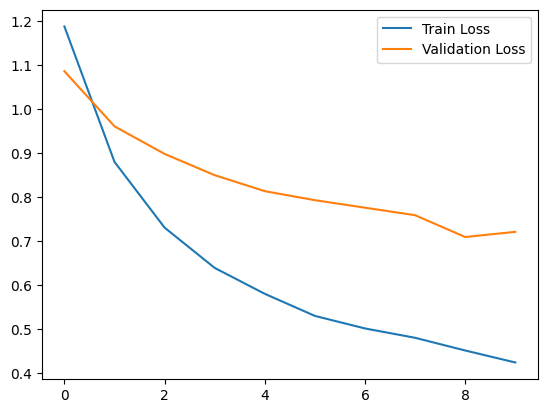

In [10]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


#Evaluate on Validation/Test Data

In [11]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc*100:.2f}%")


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 417ms/step - accuracy: 0.7745 - loss: 0.6786
Validation Accuracy: 75.35%


#Predict on a Single Image

In [13]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Path to one test image
img_path = "/content/leukemia/Segmented/Early/WBC-Malignant-Early-001.jpg" #now i take a image from Early dataset, for check it work or not

# Load and preprocess
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
class_labels = list(train_gen.class_indices.keys())
print("Predicted Class:", class_labels[np.argmax(pred)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Early


#Confusion Matrix (See Misclassifications)

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get predictions for validation set
y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 518ms/step
Confusion Matrix:
 [[13 50  8 29]
 [23 71 34 69]
 [22 62 38 70]
 [17 53 26 64]]
              precision    recall  f1-score   support

      Benign       0.17      0.13      0.15       100
       Early       0.30      0.36      0.33       197
         Pre       0.36      0.20      0.26       192
         Pro       0.28      0.40      0.33       160

    accuracy                           0.29       649
   macro avg       0.28      0.27      0.26       649
weighted avg       0.29      0.29      0.28       649

